prices/ak-47-asiimov-field-tested_buff.csv processing...
(173, 2)
prix           float64
date    datetime64[ns]
dtype: object
          prix
count  173.000
mean    20.239
std      1.552
min     17.190
25%     18.838
50%     20.330
75%     21.664
max     22.747


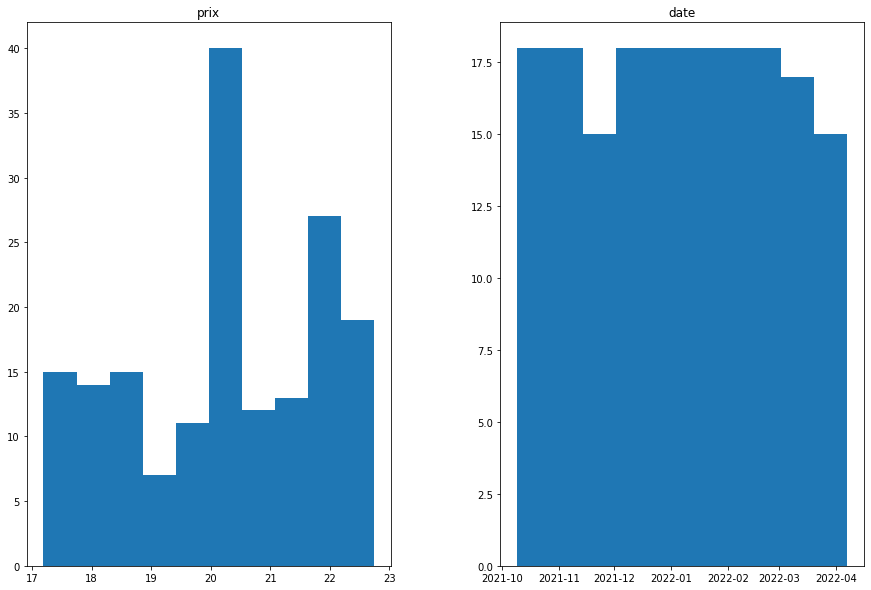

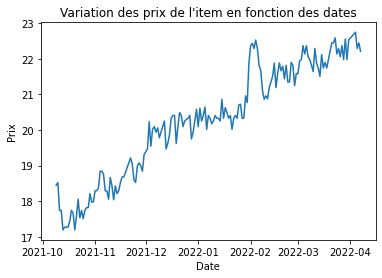

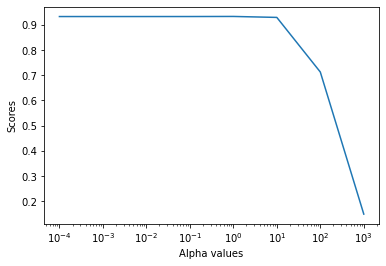

Comparaison des scores entre training, validation et test :  0.9187448219572856 0.9329839215481479 0.8594995123276598
train error 0.2022786406926622
test error 0.2228771368357741
R^2 (best possible value is 1.0) : 0.8594995123276598
The mean absolute error is: 0.37
[-1.41383655  0.5142075  -1.3983338  -0.24632467 -1.24943382]
Mean absolute error : 0.9644272686529749
Wow, very accurate model !


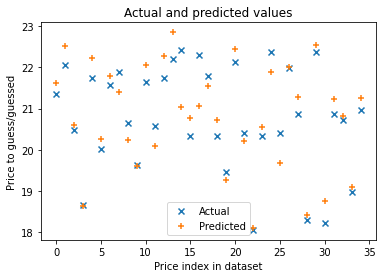

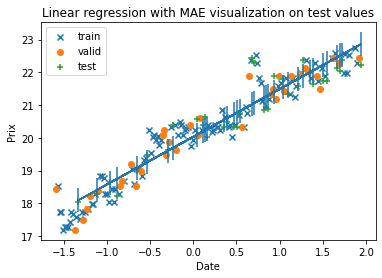

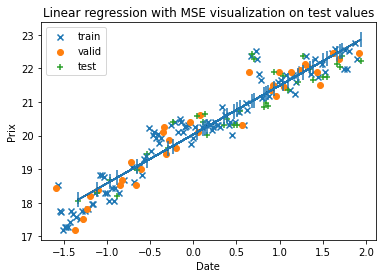

theta0 = 20.03331758394175
theta1 = 1.4568138622048197
merged_prices/ak-47-asiimov-field-tested.csv processing...
(172, 2)
prix           float64
date    datetime64[ns]
dtype: object
          prix
count  172.000
mean    20.489
std      1.236
min     17.830
25%     19.663
50%     20.418
75%     21.410
max     22.942


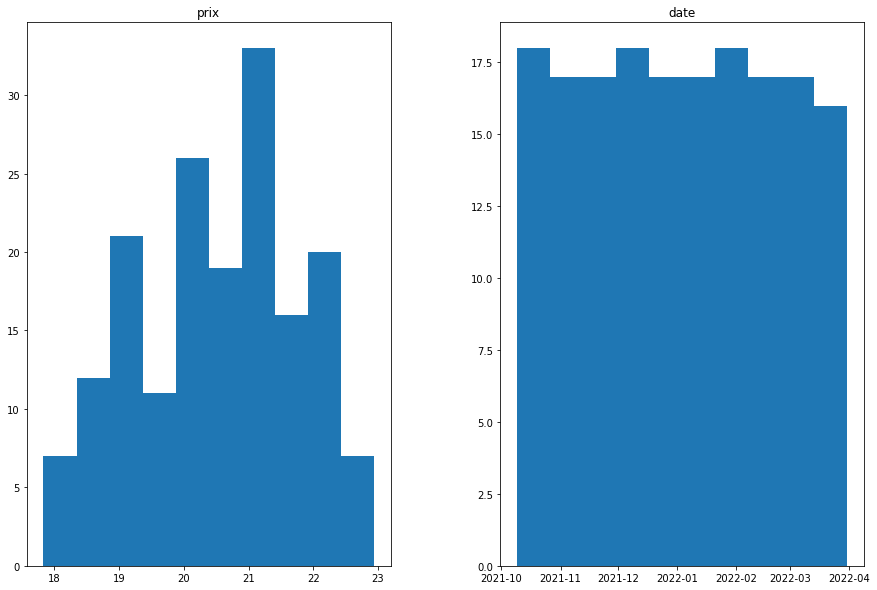

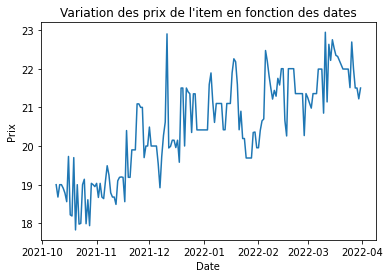

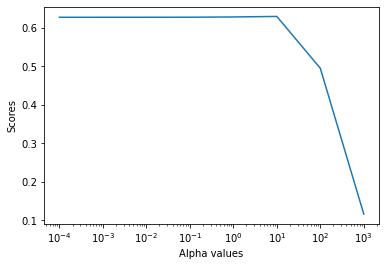

Comparaison des scores entre training, validation et test :  0.7321304735182158 0.6296758439700414 0.48977822846204533
train error 0.41417364437943943
test error 0.6858858390402232
R^2 (best possible value is 1.0) : 0.48977822846204533
The mean absolute error is: 0.62
[-3.46048389  0.01044139 -0.89836656  0.18277763 -0.12711622]
Mean absolute error : 0.9358371360062016
Wow, very accurate model !


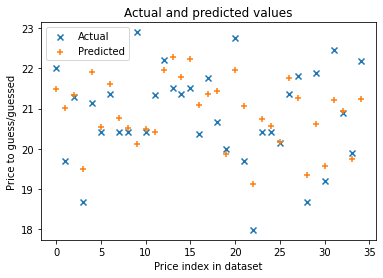

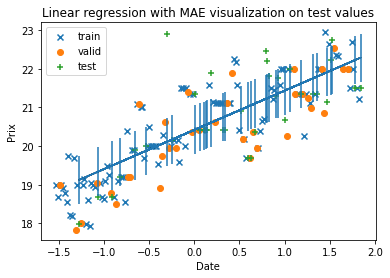

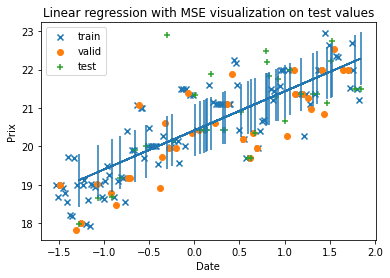

theta0 = 20.417277450980365
theta1 = 1.015347938127239
Corrélation de Pearson entre le marché chinois et le marché EU pour merged_prices/ak-47-asiimov-field-tested.csv : 0.771
Chinese prices are approximately in advance of 3 compared to EU prices.


In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import *
import sklearn.linear_model
import sklearn.preprocessing
import os
import statistics
import glob
import time as clock
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.ion()

def pearson(X,Y):
    try:
        mX = sum(X)/len(X) # mean of X and Y lists
        mY = sum(Y)/len(Y)
    
        cov = sum((a - mX) * (b - mY) for (a,b) in zip(X,Y)) / len(X) # covariance between X and Y
    
        stdevX = (sum((a - mX)**2 for a in X)/len(X))**0.5 # standard deviation of X and Y
        stdevY = (sum((a - mY)**2 for a in Y)/len(Y))**0.5
    
        return round(cov/(stdevX*stdevY),3) # pearson correlation calculation
    except:
        return 0

def calculate_days(date1,date2):
    return pd.Timedelta((date2 - date1)).days
            
def apprendre_skin(filename):
    print(filename + " processing...")
    dataset = pd.read_csv(filename)
    try:
        dataset["prix"] = dataset["prix"].astype(float)
        dataset["date"] = pd.to_datetime(dataset["date"])
        dataset.sort_values(by=['date'], inplace=True) # to force good looking data and better processing

        # analyses sommaires
        print(dataset.shape)

        # on consulte les types des données:
        print(dataset.dtypes)

        # aperçu des stats de chaque colonne
        pd.set_option('precision', 3)
        print(dataset.describe())
    
        # histograms
        dataset.hist(bins=10,figsize=(15,10),grid=False)
        plt.show()

        # Setting X and Y axis
        x = dataset['date'].values
        x = x.reshape(-1,1)
        y = dataset['prix'].values
    
        plt.title("Variation des prix de l'item en fonction des dates")
        plt.xlabel("Date")
        plt.ylabel("Prix")
        plt.plot(x,y)
        plt.show()
        
        # Train / Validation / Test split (60%/20%/20%), arbitrary defined values
        X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=7)
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=8) # 0.25 * (1-0.2) = 0.2
        
        alpha_values = np.logspace(-4,3,8) # since most inflexions are at 10^1...
    
        # input standardization
        scaler = sklearn.preprocessing.StandardScaler()
        scaler.fit(X_train)

        X_train = scaler.transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        scores = []
        for alpha in alpha_values:
            # alpha est fixé (comme mu=mu0)
            monModele = sklearn.linear_model.Ridge(alpha=alpha)
    
            # je converge theta vers theta*
            monModele.fit(X_train, Y_train)
    
            score = monModele.score(X_val, Y_val)
            scores.append(score)
        
        plt.xlabel("Alpha values")
        plt.ylabel("Scores")
        plt.semilogx(alpha_values, scores)
        plt.show()
        
        alpha_etoile = np.argmax(np.array(scores))

        # Fitting with fixed hyper-parameter
        monModele = sklearn.linear_model.Ridge(alpha=alpha_etoile)
        monModele.fit(X_train, Y_train)
        print("Comparaison des scores entre training, validation et test : ", monModele.score(X_train, Y_train), monModele.score(X_val, Y_val), monModele.score(X_test, Y_test))
    
        # Predictions
        Y_train_pred = monModele.predict(X_train)
        print("train error", sklearn.metrics.mean_squared_error(Y_train_pred, Y_train))

        Y_test_pred = monModele.predict(X_test)
        mse = sklearn.metrics.mean_squared_error(Y_test_pred, Y_test)
        print("test error", mse)
    
        # R^2 calculation
        print("R^2 (best possible value is 1.0) :", sklearn.metrics.r2_score(Y_test,Y_test_pred))
    
        # MAE calculation
        mae = sklearn.metrics.mean_absolute_error(Y_test,Y_test_pred)
        print("The mean absolute error is: {:.2f}".format(mae))
        
        # ----- Cross-validation -----
        kfold_validation=KFold(5)

        results=cross_val_score(monModele,scaler.transform(x),y,cv=kfold_validation)
        print(results)
        print("Mean absolute error :", np.mean(np.absolute(results)))
        if np.mean(np.absolute(results)) < 1:
            print("Wow, very accurate model !")

    
        plt.scatter(x=range(0,Y_test.size), y=Y_test, marker='x', label='Actual')
        plt.scatter(x=range(0,Y_test_pred.size) , y=Y_test_pred, marker='+', label='Predicted')
        plt.xlabel('Price index in dataset')
        plt.ylabel('Price to guess/guessed')
        plt.legend()
        plt.title("Actual and predicted values")
        plt.show()
    
        # Visualization with MAE on test values
        plt.scatter(X_train, Y_train, marker='x', label='train')
        plt.scatter(X_val,Y_val, marker='o', label='valid')
        plt.scatter(X_test, Y_test, marker='+', label='test')
    
        plt.legend()
        plt.title("Linear regression with MAE visualization on test values")
        plt.xlabel('Date')
        plt.ylabel('Prix')
        plt.errorbar(X_test,Y_test_pred,mae)
        plt.plot(X_test, Y_test_pred, color = "black")
        plt.show()

    
        # Visualization with MSE on test values
        plt.scatter(X_train, Y_train, marker='x', label='train')
        plt.scatter(X_val,Y_val, marker='o', label='valid')
        plt.scatter(X_test, Y_test, marker='+', label='test')
    
        plt.legend()
        plt.title("Linear regression with MSE visualization on test values")
        plt.xlabel('Date')
        plt.ylabel('Prix')
        plt.errorbar(X_test,Y_test_pred,mse)
        plt.plot(X_test, Y_test_pred, color = "black")
        plt.show()
        
        print('theta0 =', monModele.intercept_)
        print('theta1 =', monModele.coef_[0])
        
        day_stand = scaler.transform(x)
        
        l=[]
        for sing in day_stand:
            l.append(sing[0])
        
        return x,y,monModele.intercept_,monModele.coef_[0],(max(l)-min(l))/len(l),max(l),mse,statistics.mean(y)
    except:
        print("Il n'y a aucun prix pour", filename)
        return np.empty(0),np.empty(0,dtype='datetime64[ns]'),0,0,0,0,0,0

def find_bestPearson(x,y,days_x,days_y,curr_cp,nb_days,max_cp): # param : x list and y list to find best Pearson correlation, days which corresponds to x and y lists, and cp the initial pearson found. nb_days is the INOUT parameter, which is initialized at 0 in first call, and stands for the gap of days between chinese and selected EU markets. max_cp is the maximum Pearson corr found
    if y[0]>x[-1]:
        return nb_days
    else:
        y = y[1:]
        curr_cp = abs(pearson(x,y))
        if curr_cp > max_cp:
            nb_days = calculate_days(days_x[0][0],days_y[1][0]) # number of days between beginning of chinese market and supposed correlation with EU market
            return find_bestPearson(x,y,days_x,days_y[1:],curr_cp,nb_days,curr_cp)
        else:
            return find_bestPearson(x,y,days_x,days_y[1:],curr_cp,nb_days,max_cp)

def asking_days(b,b0_cn,b1_cn,b0_eu,b1_eu,max_cn,std_diff_cn,std_diff_eu,max_eu,mse_cn,mse_eu):
    while b==True:
        nb_jours = input("Entrez le nombre de jours à prédire (7 = prix du skin dans une semaine par exemple) :")
        nb_jours = int(nb_jours)
        print("Prix possible dans", nb_jours,"jour(s) pour",dirct_eu[0], "en Chine :", b0_cn+b1_cn*(max_cn+std_diff_cn*nb_jours))
        print("Prix minimal Chine dans :", nb_jours,"jour(s) :",(b0_cn+b1_cn*(max_cn+std_diff_cn*nb_jours))-mse_cn/2)
        print("Prix maximal Chine dans :", nb_jours,"jour(s) :",(b0_cn+b1_cn*(max_cn+std_diff_cn*nb_jours))+mse_cn/2)
        print("Prix possible dans", nb_jours,"jour(s) pour",dirct_eu[0], "en Europe :", b0_eu+b1_eu*(max_eu+std_diff_eu*nb_jours))
        #print("Prix minimal Europe dans :", nb_jours,"jour(s) :",(b0_cn+b1_cn*(max_eu+std_diff_eu*nb_jours))-mse_eu/2) not enough values to achieve accuracy
        #print("Prix maximal Europe dans :", nb_jours,"jour(s) :",(b0_eu+b1_eu*(max_eu+std_diff_eu*nb_jours))+mse_eu/2) not enough values to achieve accuracy
        
        test = input("Voulez-vous continuer ? O = Oui N = Non")
        if (test=='N'):
            b=False
            

dirct_cn = glob.glob('prices/*buff.csv')
dirct_cn.sort()

dirct_eu = glob.glob('merged_prices/*.csv')
dirct_eu.sort()

store_cn = []
store_eu = []
for csv_cn in dirct_cn:
    x_cn,y_cn,b0_cn,b1_cn,std_diff_cn,max_cn,mse_cn,mean_cn = apprendre_skin(csv_cn)
    x_eu,y_eu,b0_eu,b1_eu,std_diff_eu,max_eu,mse_eu,mean_eu = apprendre_skin(dirct_eu[0])
    
    corr = pearson(y_cn,y_eu) # pearson correlation
    
    print("Corrélation de Pearson entre le marché chinois et le marché EU pour", dirct_eu[0], ":", corr)
    try:
        # chinese deviation between two dates instead of EU due to a better accuracy
        nb_days = find_bestPearson(y_cn.tolist(),y_eu.tolist(),x_cn,x_eu,corr,0,corr) # needs to have a great day coverage (~1 data/day) to be accurate
        print("Chinese prices are approximately in advance of", nb_days, "compared to EU prices.")
    except:
        nb_days = 0
        print("Empty data for "+dirct_eu[0])
    
    asking_days(True,b0_cn,b1_cn,b0_eu,b1_eu,max_cn,std_diff_cn,std_diff_eu,max_eu,mse_cn,mse_eu) # using standardized difference between two days

    store_cn.append([csv_cn.split('.')[0].split('_')[0].split('/')[1],nb_days,mean_cn,corr,b1_cn,b0_cn])
    store_eu.append([dirct_eu[0].split('.')[0].split('/')[1],nb_days,mean_eu,corr,b1_eu,b0_eu])
    
    dirct_eu = dirct_eu[1:]

names = ['item_name','nb_days_between_markets','avg_price','corr_otherMarket','reg_coef','reg_origin']
data_cn = pd.DataFrame(store_cn, columns=names)
data_eu = pd.DataFrame(store_eu, columns=names)
data_cn.to_csv('data_cn.csv',index=False)
data_eu.to_csv('data_eu.csv',index=False)